In [1]:
from copy import deepcopy
import os
import pickle

import cv2

from matplotlib import pyplot as plt


import numpy as np
from PIL import Image

from handobjectdatasets.queries import TransQueries, BaseQueries
from handobjectdatasets.viz2d import visualize_joints_2d_cv2

from mano_train.exputils import argutils
from mano_train.netscripts.reload import reload_model
from mano_train.visualize import displaymano
from mano_train.demo.preprocess import prepare_input, preprocess_frame

from functools import partial
import matplotlib.pyplot as plt
from pycpd import DeformableRegistration
from pycpd import RigidRegistration
from pycpd import AffineRegistration

In [2]:
# Define Function
def forward_pass_3d(model, input_image, pred_obj=True):
    sample = {}
    sample[TransQueries.images] = input_image
    sample[BaseQueries.sides] = ["left"]
    sample[TransQueries.joints3d] = input_image.new_ones((1, 21, 3)).float()
    sample["root"] = "wrist"
    if pred_obj:
        sample[TransQueries.objpoints3d] = input_image.new_ones((1, 600, 3)).float()
    _, results, _ = model.forward(sample, no_loss=True)
    return results

def forward_pass_2d(model_hands, input_image, pred_obj=True):
    sample = {}
    sample[TransQueries.images] = input_image
    sample[BaseQueries.sides] = ["left"]
    sample[TransQueries.joints3d] = input_image.new_ones((1, 21, 3)).float()
    sample["root"] = "wrist"
    if pred_obj:
        sample[TransQueries.objpoints3d] = input_image.new_ones((1, 600, 3)).float()
    _, results, _ = model_hands.forward(sample, no_loss=True)

    return results

In [197]:
class obman_prediction(object):

    def __init__(self, image_dir_path, save_predict_path, save_pose_estimation_path, save_subplot_output_path, mode):
        # Image List
        image_list = os.listdir(image_dir_path)
        
        # Define Model
        checkpoint_obman = os.path.dirname("release_models/obman/checkpoint.pth.tar")
        checkpoint_hand = os.path.dirname("release_models/hands_only/checkpoint.pth.tar")

        with open(os.path.join(checkpoint_obman, "opt.pkl"), "rb") as opt_fo:
            opts_obman = pickle.load(opt_fo)

        with open(os.path.join(checkpoint_hand, "opt.pkl"), "rb") as opt_fh:
            opts_hands = pickle.load(opt_fh)

        # Initialize network
        model_obman = reload_model("release_models/obman/checkpoint.pth.tar", opts_obman)
        model_obman.eval()

        model_hands = reload_model("release_models/hands_only/checkpoint.pth.tar", opts_hands)
        model_hands.eval()

        # load faces of hand
        with open("misc/mano/MANO_RIGHT.pkl", "rb") as p_f:
            mano_right_data = pickle.load(p_f, encoding="latin1")
            faces = mano_right_data["f"]
            
        # Choose Mode = Right
        if mode == "right":
            
            for image_index in range(len(image_list)): 
            # Processing
                fig = plt.figure(figsize=(4, 4))
                fig.clf()
                frame = cv2.imread(os.path.join(image_dir_path, image_list[image_index]))
                frame = preprocess_frame(frame)
                input_image = prepare_input(frame)
                img = Image.fromarray(frame.copy())
                hand_crop = cv2.resize(np.array(img), (256, 256))

                flip_fig = plt.figure(figsize=(4, 4))

                flip_hand_image = prepare_input(hand_crop, flip_left_right=True)
                flip_3D_output = forward_pass_3d(model_obman, flip_hand_image)
                flip_2D_output = forward_pass_2d(model_hands, flip_hand_image)
                flip_image = deepcopy(np.flip(hand_crop, axis=1))
                if "joints2d" in flip_2D_output:
                    joints2d = flip_2D_output["joints2d"].cpu().detach().numpy()[0]
                    flip_image = visualize_joints_2d_cv2(flip_image, joints2d)

                flip_verts = flip_3D_output["verts"].cpu().detach().numpy()[0]
                flip_ax = flip_fig.add_subplot(1, 1, 1, projection="3d")
                displaymano.add_mesh(flip_ax, flip_verts, faces, flip_x=True)

                if "objpoints3d" in flip_3D_output:
                    objverts = flip_3D_output["objpoints3d"].cpu().detach().numpy()[0]
                    displaymano.add_mesh(flip_ax, objverts, flip_3D_output["objfaces"], flip_x=True, c="r")    

            # ================= Coherent Point Drift for matching =================	
                target = np.array([joints2d[0], joints2d[4], joints2d[8], joints2d[12], joints2d[16], joints2d[20]])
                source = np.array([flip_verts[279][:2], flip_verts[730][:2], flip_verts[317][:2], flip_verts[443][:2], flip_verts[556][:2], flip_verts[673][:2]])

                reg = AffineRegistration(**{'X': target, 'Y': source})
                TY, _ = reg.register()
                self.B, self.t = AffineRegistration.get_registration_parameters(reg)  

                # ================= Hand Point =================
                for i in range(21):
                    joints2d[i][0] = int(640 - joints2d[i][0]*2.5)
                    joints2d[i][1] = int(joints2d[i][1]*1.875)

                
            # ================= Object Point =================
                for index, obj_points in enumerate(objverts):
                    obj_point = AffineRegistration.transform_point_cloud(self, obj_points[:2])
                    obj_point = obj_point.astype(np.float32)
                    obj_visualize = obj_point.astype(np.float32)
                    vis_obj = tuple(obj_visualize[0])

                    if index == 438:
                        cv2.circle(flip_image, vis_obj, 1, (0, 0, 255), 8)
                        
            # ================= Pose Estimation =================
                flip_fig.canvas.draw()
                w, h = flip_fig.canvas.get_width_height()
                predict_flip = np.fromstring(flip_fig.canvas.tostring_argb(), dtype=np.uint8)
                predict_flip.shape = (w, h, 4)

                converted_img = cv2.cvtColor(predict_flip, cv2.COLOR_BGRA2BGR)


                # Find contours
                gs_frame = cv2.GaussianBlur(converted_img, (5, 5), 0)                   
                hsv = cv2.cvtColor(gs_frame, cv2.COLOR_BGR2HSV)                 
                erode_hsv = cv2.erode(hsv, None, iterations=2)                 
                inRange_hsv = cv2.inRange(erode_hsv, np.array([100, 43, 46]), np.array([119, 255, 255]))
                cnts = cv2.findContours(inRange_hsv.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
                c = max(cnts, key=cv2.contourArea)
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                cv2.drawContours(converted_img, [np.int0(box)], -1, (0, 0, 255), 2)
                
                
            # ================= Save and Display =================    
                image_name = image_list[image_index].split('.')[0] + ".png"
                
                plt.figure(figsize=(8,8))

                plt.subplot(1, 3, 1)
                plt.title("Origin Image")
                plt.imshow(hand_crop[:, :, ::-1])

                plt.subplot(1, 3, 2)
                plt.title("Predict")
                plt.imshow(cv2.flip(flip_image[:, :, ::-1], 1))
                plt.imsave(os.path.join(save_predict_path, image_list[image_index]), cv2.flip(flip_image[:, :, ::-1], 1))

                plt.subplot(1, 3, 3)
                plt.title("Pose Estimation")
                plt.imshow(converted_img[:, :, ::-1])
                plt.imsave(os.path.join(save_pose_estimation_path, image_name), converted_img[:, :, ::-1])

                plt.savefig(os.path.join(save_subplot_output_path, image_name))
        
        
        # Choose Mode = Left
        if mode == "left":
            
            for image_index in range(len(image_list)): 
            # Processing
                fig = plt.figure(figsize=(4, 4))
                fig.clf()
                frame = cv2.imread(os.path.join(image_dir_path, image_list[image_index]))
                frame = preprocess_frame(frame)
                input_image = prepare_input(frame)
                img = Image.fromarray(frame.copy())
                hand_crop = cv2.resize(np.array(img), (256, 256))

                noflip_fig = plt.figure(figsize=(4, 4))

                noflip_hand_image = prepare_input(hand_crop, flip_left_right=False)
                noflip_3D_output = forward_pass_3d(model_obman, noflip_hand_image)
                noflip_2D_output = forward_pass_2d(model_hands, noflip_hand_image)
                noflip_image = deepcopy(hand_crop)
                if "joints2d" in noflip_2D_output:
                    joints2d = noflip_2D_output["joints2d"].cpu().detach().numpy()[0]
                    noflip_image = visualize_joints_2d_cv2(noflip_image, joints2d)

                noflip_verts = noflip_3D_output["verts"].cpu().detach().numpy()[0]
                noflip_ax = noflip_fig.add_subplot(1, 1, 1, projection="3d")
                displaymano.add_mesh(noflip_ax, noflip_verts, faces, flip_x=False)

                if "objpoints3d" in noflip_3D_output:
                    objverts = noflip_3D_output["objpoints3d"].cpu().detach().numpy()[0]
                    displaymano.add_mesh(noflip_ax, objverts, noflip_3D_output["objfaces"], flip_x=False, c="r")    

            # ================= Coherent Point Drift for matching =================	
                target = np.array([joints2d[0], joints2d[4], joints2d[8], joints2d[12], joints2d[16], joints2d[20]])
                source = np.array([noflip_verts[279][:2], noflip_verts[730][:2], noflip_verts[317][:2], noflip_verts[443][:2], noflip_verts[556][:2], noflip_verts[673][:2]])

                reg = AffineRegistration(**{'X': target, 'Y': source})
                TY, _ = reg.register()
                self.B, self.t = AffineRegistration.get_registration_parameters(reg)  

                # ================= Hand Point =================
                for i in range(21):
                    joints2d[i][0] = int(640 - joints2d[i][0]*2.5)
                    joints2d[i][1] = int(joints2d[i][1]*1.875)

                
            # ================= Object Point =================
                for index, obj_points in enumerate(objverts):
                    obj_point = AffineRegistration.transform_point_cloud(self, obj_points[:2])
                    obj_point = obj_point.astype(np.float32)
                    obj_visualize = obj_point.astype(np.float32)
                    vis_obj = tuple(obj_visualize[0])

                    if index == 438:
                        cv2.circle(noflip_image, vis_obj, 1, (0, 0, 255), 8)
                        
            # ================= Pose Estimation =================
                noflip_fig.canvas.draw()
                w, h = noflip_fig.canvas.get_width_height()
                predict_noflip = np.fromstring(noflip_fig.canvas.tostring_argb(), dtype=np.uint8)
                predict_noflip.shape = (w, h, 4)

                converted_img = cv2.cvtColor(predict_noflip, cv2.COLOR_BGRA2BGR)


                # Find contours
                gs_frame = cv2.GaussianBlur(converted_img, (5, 5), 0)                   
                hsv = cv2.cvtColor(gs_frame, cv2.COLOR_BGR2HSV)                 
                erode_hsv = cv2.erode(hsv, None, iterations=2)                 
                inRange_hsv = cv2.inRange(erode_hsv, np.array([100, 43, 46]), np.array([119, 255, 255]))
                cnts = cv2.findContours(inRange_hsv.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
                c = max(cnts, key=cv2.contourArea)
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                cv2.drawContours(converted_img, [np.int0(box)], -1, (0, 0, 255), 2)
                
                
            # ================= Save and Display =================    
                image_name = image_list[image_index].split('.')[0] + ".png"
                
                plt.figure(figsize=(16,16))

                plt.subplot(1, 3, 1)
                plt.title("Origin Image")
                plt.imshow(hand_crop[:, :, ::-1])

                plt.subplot(1, 3, 2)
                plt.title("Predict")
                plt.imshow(noflip_image[:, :, ::-1])
                plt.imsave(os.path.join(save_predict_path, image_list[image_index]), noflip_image[:, :, ::-1])

                plt.subplot(1, 3, 3)
                plt.title("Pose Estimation")
                plt.imshow(converted_img[:, :, ::-1])
                plt.imsave(os.path.join(save_pose_estimation_path, image_name), converted_img[:, :, ::-1])

                plt.savefig(os.path.join(save_subplot_output_path, image_name))


=> loading checkpoint 'release_models/obman/checkpoint.pth.tar'
=> loading checkpoint 'release_models/hands_only/checkpoint.pth.tar'


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 288x288 with 0 Axes>

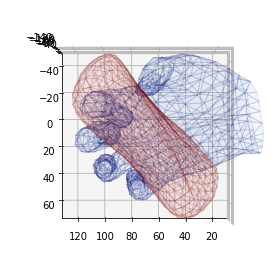

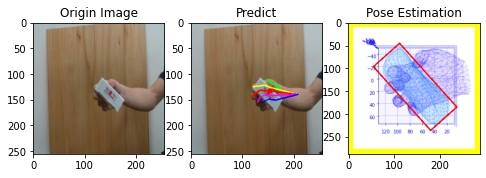

<Figure size 288x288 with 0 Axes>

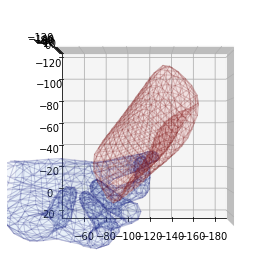

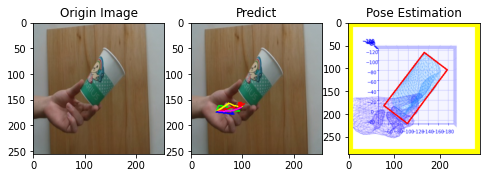

<Figure size 288x288 with 0 Axes>

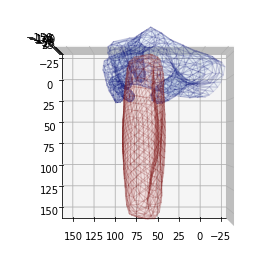

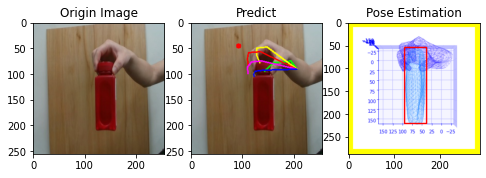

<Figure size 288x288 with 0 Axes>

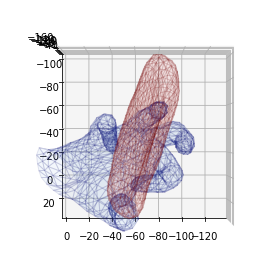

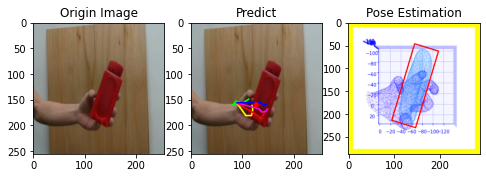

<Figure size 288x288 with 0 Axes>

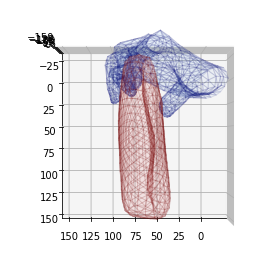

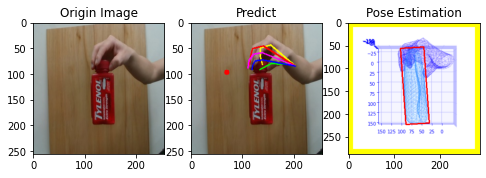

<Figure size 288x288 with 0 Axes>

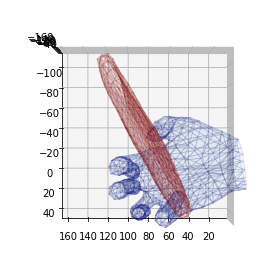

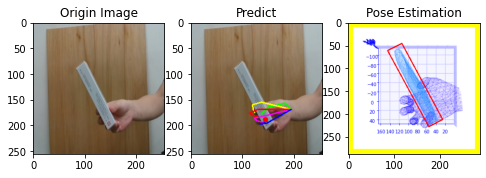

<Figure size 288x288 with 0 Axes>

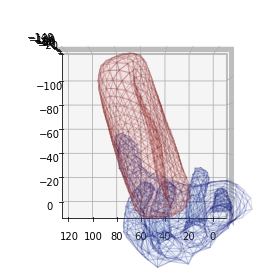

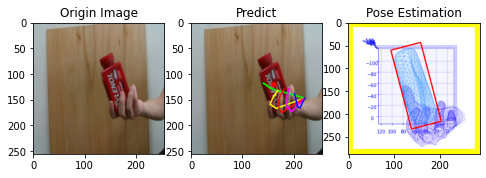

<Figure size 288x288 with 0 Axes>

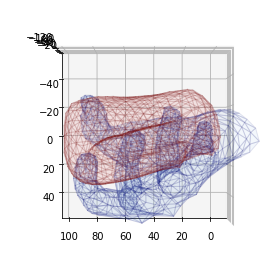

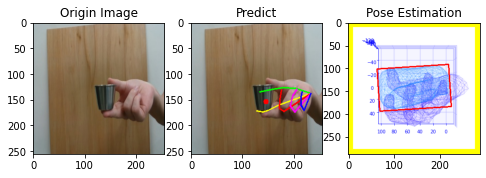

<Figure size 288x288 with 0 Axes>

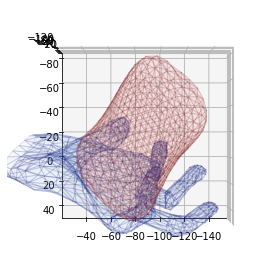

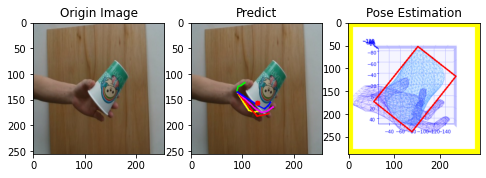

<Figure size 288x288 with 0 Axes>

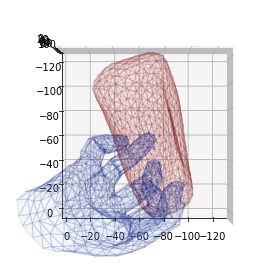

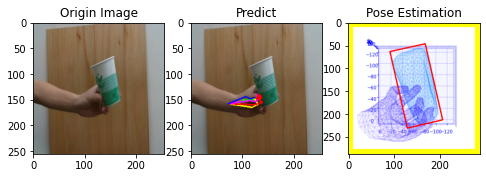

<Figure size 288x288 with 0 Axes>

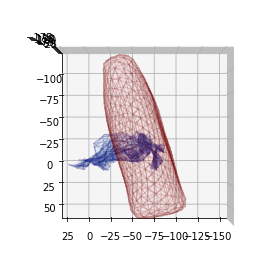

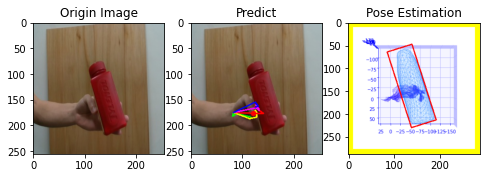

<Figure size 288x288 with 0 Axes>

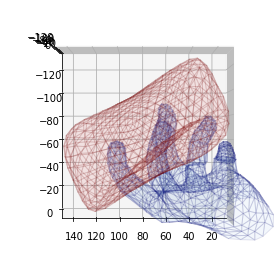

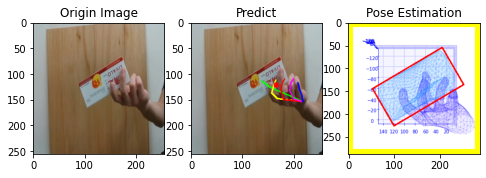

<Figure size 288x288 with 0 Axes>

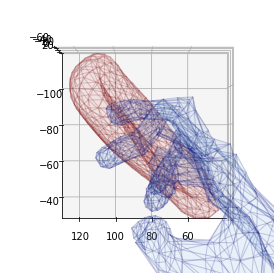

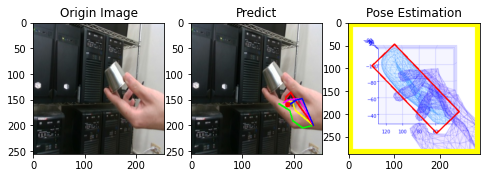

<Figure size 288x288 with 0 Axes>

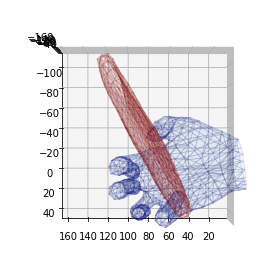

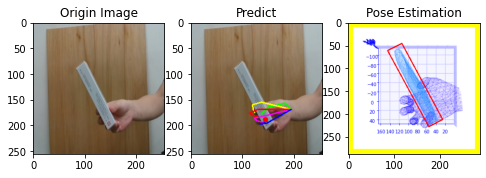

<Figure size 288x288 with 0 Axes>

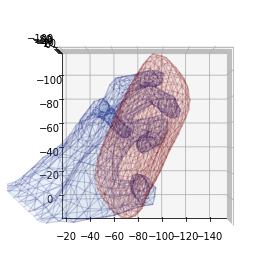

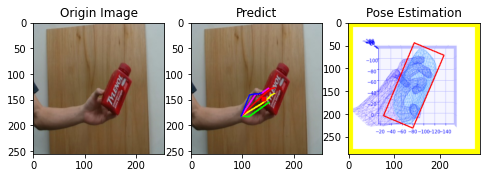

<Figure size 288x288 with 0 Axes>

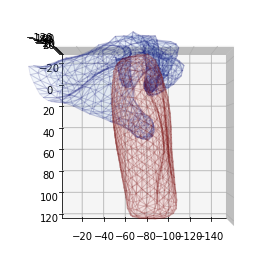

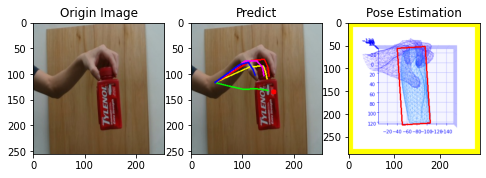

<Figure size 288x288 with 0 Axes>

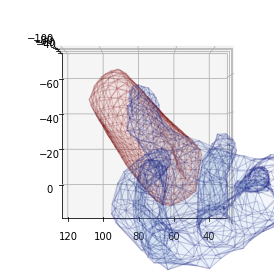

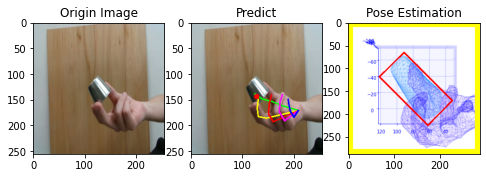

<Figure size 288x288 with 0 Axes>

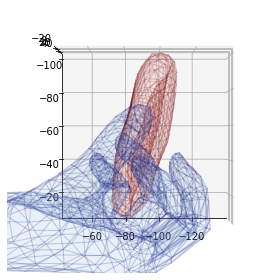

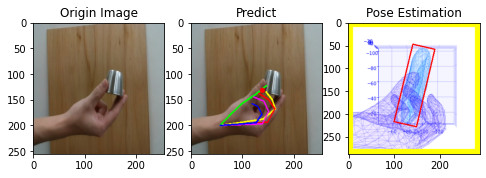

<Figure size 288x288 with 0 Axes>

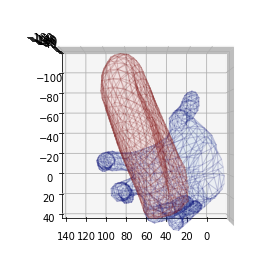

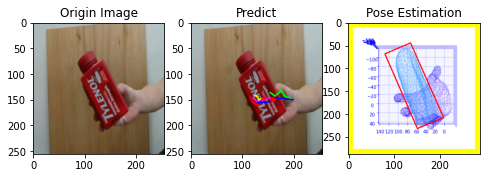

<Figure size 288x288 with 0 Axes>

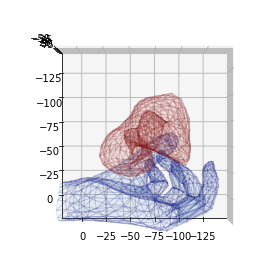

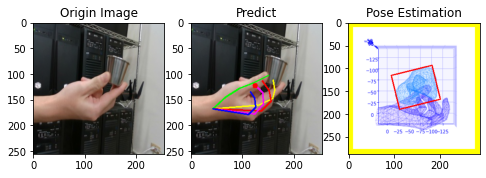

<Figure size 288x288 with 0 Axes>

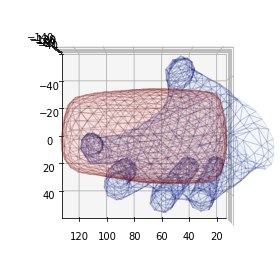

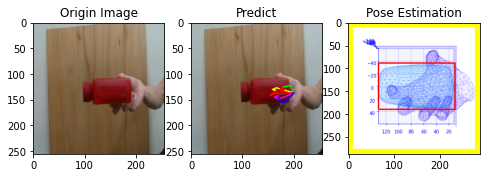

<Figure size 288x288 with 0 Axes>

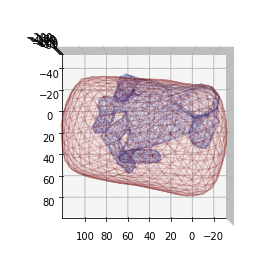

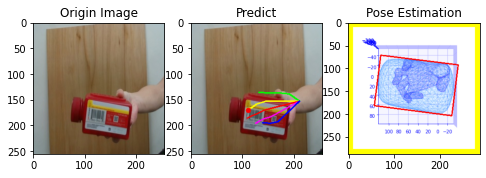

In [198]:
if __name__ == '__main__': 
    # Parameter
    image_dir_path = "readme_assets/images/test/"
    save_predict_path = "readme_assets/images/predict/"
    save_pose_estimation_path = "readme_assets/images/pose_estimation/"
    save_subplot_output_path = "readme_assets/images/subplot_output/"
    mode = "right"
    
    
    obman_prediction = obman_prediction(image_dir_path, save_predict_path, save_pose_estimation_path, save_subplot_output_path, mode)